### 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

Illegal line #217
	"       - 'Nanum'
"
	in file "/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc"


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
train_data.shape

(150000, 3)

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


### 2) 데이터로더 구성    
실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
# index_to_word
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델구성을 위한 데이터 분석 및 가공    
- 데이터셋 내 문장 길이 분포   
- 적절한 최대 문장 길이 지정    
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가    

In [7]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


### 4) 모델구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [9]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(126182, 41)
(126182,)
(20000, 41)
(20000,)


In [10]:
vocab_size = len(index_to_word) # 어휘 사전의 크기
word_vector_dim = 300            # 워드 벡터의 차원수

In [11]:
#RNN

RNN_model = keras.Sequential(name="RNN")
RNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
RNN_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
RNN_model.add(keras.layers.MaxPooling1D(5))
RNN_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
RNN_model.add(keras.layers.GlobalMaxPooling1D())
RNN_model.add(keras.layers.Dense(8, activation='relu'))
RNN_model.add(keras.layers.Dense(1, activation='sigmoid'))

RNN_model.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9       

In [12]:
# CNN

CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(256, 7, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         537856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          114752    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9       

In [13]:
# LSTM

LSTM_model = keras.Sequential(name="LSTM")
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(8, dropout=0.7))
LSTM_model.add(keras.layers.Dense(8, activation='relu'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [16]:
#RNN

RNN_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])
              
epochs= 10
RNN_history = RNN_model.fit(partial_X_train, partial_y_train,
                    epochs=epochs, batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

RNN_results = RNN_model.evaluate(X_test, y_test, verbose = 2)
print(RNN_results)

Epoch 1/10
247/247 [==============================] - 7s 27ms/step - loss: 0.0396 - accuracy: 0.9862 - val_loss: 0.7228 - val_accuracy: 0.8350
Epoch 2/10
247/247 [==============================] - 7s 27ms/step - loss: 0.0289 - accuracy: 0.9901 - val_loss: 0.8064 - val_accuracy: 0.8352
Epoch 3/10
247/247 [==============================] - 7s 27ms/step - loss: 0.0219 - accuracy: 0.9925 - val_loss: 0.9410 - val_accuracy: 0.8302
Epoch 4/10
247/247 [==============================] - 7s 27ms/step - loss: 0.0205 - accuracy: 0.9927 - val_loss: 1.0007 - val_accuracy: 0.8303
Epoch 5/10
247/247 [==============================] - 7s 27ms/step - loss: 0.0254 - accuracy: 0.9908 - val_loss: 0.9468 - val_accuracy: 0.8366
Epoch 6/10
247/247 [==============================] - 7s 27ms/step - loss: 0.0262 - accuracy: 0.9905 - val_loss: 0.9732 - val_accuracy: 0.8356
Epoch 7/10
247/247 [==============================] - 7s 26ms/step - loss: 0.0205 - accuracy: 0.9926 - val_loss: 1.0460 - val_accuracy: 0.8273

In [17]:
#CNN

CNN_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])
              
epochs= 10
CNN_history = CNN_model.fit(partial_X_train, partial_y_train,
                    epochs=epochs, batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

CNN_results = CNN_model.evaluate(X_test, y_test, verbose = 2)
print(CNN_results)

Epoch 1/10
247/247 [==============================] - 15s 61ms/step - loss: 0.4229 - accuracy: 0.7901 - val_loss: 0.3302 - val_accuracy: 0.8547
Epoch 2/10
247/247 [==============================] - 9s 35ms/step - loss: 0.2821 - accuracy: 0.8818 - val_loss: 0.3295 - val_accuracy: 0.8573
Epoch 3/10
247/247 [==============================] - 9s 35ms/step - loss: 0.1981 - accuracy: 0.9228 - val_loss: 0.3528 - val_accuracy: 0.8569
Epoch 4/10
247/247 [==============================] - 9s 34ms/step - loss: 0.1136 - accuracy: 0.9594 - val_loss: 0.4470 - val_accuracy: 0.8526
Epoch 5/10
247/247 [==============================] - 9s 35ms/step - loss: 0.0665 - accuracy: 0.9777 - val_loss: 0.5578 - val_accuracy: 0.8474
Epoch 6/10
247/247 [==============================] - 9s 35ms/step - loss: 0.0430 - accuracy: 0.9859 - val_loss: 0.6637 - val_accuracy: 0.8436
Epoch 7/10
247/247 [==============================] - 9s 35ms/step - loss: 0.0307 - accuracy: 0.9900 - val_loss: 0.7832 - val_accuracy: 0.846

In [19]:
#LSTM

LSTM_model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])
              
epochs= 10
LSTM_history = LSTM_model.fit(partial_X_train, partial_y_train,
                    epochs=epochs, batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

LSTM_results = LSTM_model.evaluate(X_test, y_test, verbose = 2)
print(LSTM_results)

Epoch 1/10
247/247 [==============================] - 7s 28ms/step - loss: 0.2804 - accuracy: 0.8880 - val_loss: 0.3619 - val_accuracy: 0.8533
Epoch 2/10
247/247 [==============================] - 7s 27ms/step - loss: 0.2675 - accuracy: 0.8923 - val_loss: 0.3541 - val_accuracy: 0.8534
Epoch 3/10
247/247 [==============================] - 7s 28ms/step - loss: 0.2590 - accuracy: 0.8947 - val_loss: 0.3676 - val_accuracy: 0.8515
Epoch 4/10
247/247 [==============================] - 7s 28ms/step - loss: 0.2499 - accuracy: 0.8986 - val_loss: 0.3752 - val_accuracy: 0.8532
Epoch 5/10
247/247 [==============================] - 7s 27ms/step - loss: 0.2442 - accuracy: 0.9006 - val_loss: 0.3743 - val_accuracy: 0.8547
Epoch 6/10
247/247 [==============================] - 7s 28ms/step - loss: 0.2352 - accuracy: 0.9040 - val_loss: 0.3765 - val_accuracy: 0.8537
Epoch 7/10
247/247 [==============================] - 7s 28ms/step - loss: 0.2300 - accuracy: 0.9064 - val_loss: 0.3872 - val_accuracy: 0.8518

- LSTM     
loss: 0.4022 - accuracy: 0.8505

### 6) Loss, Accuracy 그래프 시각화

In [29]:
history_dict = LSTM_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


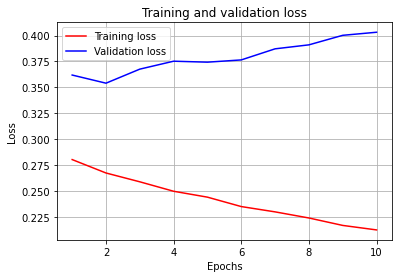

In [30]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

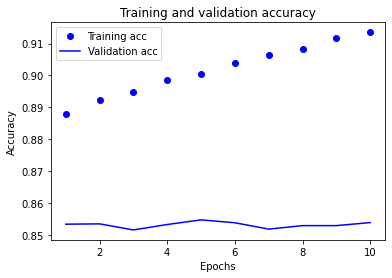

In [31]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [32]:
embedding_layer = LSTM_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [33]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['별로']

In [35]:
word_vectors.similar_by_word("별로")

[('꺼버린', 0.7402714490890503),
 ('아녀', 0.7311161160469055),
 ('재미없', 0.7228334546089172),
 ('꺼버렸', 0.7174898386001587),
 ('돌렸', 0.7136139869689941),
 ('서프라이즈', 0.7053666114807129),
 ('전무', 0.7044374942779541),
 ('실망감', 0.7016404271125793),
 ('역겨웠', 0.7016103863716125),
 ('괴로웠', 0.6984685659408569)]

'별로' 라는 단어와 가장 유사한 단어를 봤을때, 영화리뷰에서 볼 수 있는 부정적인 단어가 잘 나왔다.

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [36]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'

In [37]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load(word2vec_file_path)

In [38]:
vector = word2vec['별로']
vector

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 1.68665443e-02,  9.18045640e-01, -7.20242500e-01, -6.83554351e-01,
       -7.34229505e-01, -1.07350506e-01,  2.57092088e-01, -1.41239154e+00,
       -3.28814447e-01, -6.70715988e-01, -4.99807000e-01, -5.01364708e-01,
       -2.17055273e+00, -3.73479307e-01, -1.49181628e+00, -3.28086883e-01,
        5.54419219e-01,  4.73109990e-01,  1.62339854e+00, -6.64335668e-01,
       -8.94197702e-01, -1.89828143e-01, -1.38139045e+00,  6.56678617e-01,
        2.29216886e+00, -4.25388277e-01, -2.65674204e-01,  1.07140839e-01,
        9.34884489e-01, -1.97074771e+00, -4.77636695e-01, -9.96400058e-01,
        3.80843103e-01,  1.03787982e+00, -1.42434752e+00,  1.64766729e+00,
        2.95337319e-01, -5.24710536e-01,  3.63458037e-01, -5.67891061e-01,
       -9.78340745e-01, -3.71020913e-01, -8.24937448e-02,  4.88069862e-01,
       -1.22962976e+00,  7.26849496e-01,  2.58719295e-01, -8.65202069e-01,
       -7.28265718e-02, -8.48643005e-01,  1.60336983e+00,  1.62154436e-01,
       -2.55368757e+00, -

In [39]:
len(word2vec['별로'])

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


200

In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [41]:
embedding_matrix.shape

(10000, 200)

In [50]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8,dropout=0.7))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [51]:
# 모델 학습
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])
              
epochs= 10
history = model.fit(partial_X_train, partial_y_train,
                    epochs=epochs, batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 5s 19ms/step - loss: 0.6935 - accuracy: 0.5013 - val_loss: 0.6918 - val_accuracy: 0.5036
Epoch 2/10
247/247 [==============================] - 5s 18ms/step - loss: 0.6926 - accuracy: 0.5044 - val_loss: 0.6909 - val_accuracy: 0.5120
Epoch 3/10
247/247 [==============================] - 5s 18ms/step - loss: 0.6814 - accuracy: 0.5446 - val_loss: 0.5976 - val_accuracy: 0.6956
Epoch 4/10
247/247 [==============================] - 5s 19ms/step - loss: 0.5650 - accuracy: 0.7118 - val_loss: 0.4616 - val_accuracy: 0.7930
Epoch 5/10
247/247 [==============================] - 5s 19ms/step - loss: 0.4883 - accuracy: 0.7690 - val_loss: 0.4194 - val_accuracy: 0.8170
Epoch 6/10
247/247 [==============================] - 5s 19ms/step - loss: 0.4525 - accuracy: 0.7923 - val_loss: 0.3952 - val_accuracy: 0.8278
Epoch 7/10
247/247 [==============================] - 5s 19ms/step - loss: 0.4323 - accuracy: 0.8025 - val_loss: 0.3808 - val_accuracy: 0.8349

In [52]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3682 - accuracy: 0.8401
[0.3681723177433014, 0.8400634527206421]


- LSTM >> loss: 0.4022 - accuracy: 0.8505
- 한국어 Word2Vec 임베딩을 활용후 loss: 0.3682 - accuracy: 0.8401    

- #### acc가 오르지 않았지만, loss가 많이 떨어졌다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


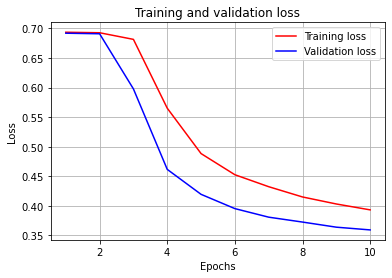

In [53]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

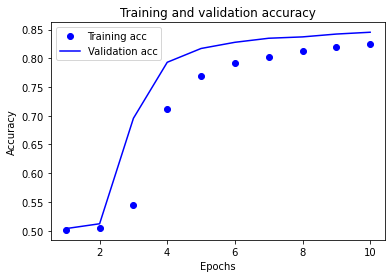

In [54]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

pre-trained word2vec를 사용하기 전의 그래프와 비교해보면 보다 안정적이다.    
사전학습된 워드임베딩 적용하기 전의 그래프를 살펴보면 epoch 수를 늘여도,    
train data는 오버피팅현상이 나타났고 validation의 acc는 변동이없었고, loss는 증가됐었다.    
사전학습된 워드임베딩 적용 후, train과 validation의 그래프가 같은 방향으로 안정적으로 그려졌다.